In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm
import numpy as np
from pathlib import Path
import random
from typing import Dict, List, Tuple, Optional
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import json
import time
from collections import defaultdict

In [4]:
base_path = '/kaggle/input/paired-dataset/paired_lensing_simulations'

file_groups = defaultdict(list)

for filename in os.listdir(base_path):
    if filename.endswith('.npy'):
        parts = filename.split('_')
        base_category = '_'.join(parts[:-1]) if parts[-1].split('.')[0].isdigit() else filename[:-4]
        
        full_path = os.path.join(base_path, filename)
        
        file_groups[base_category].append(full_path)

file_groups = dict(file_groups)

for category, files in file_groups.items():
    print(f"{category}: {len(files)} files")

cdm_source: 400 files
uldm_original: 400 files
uldm_parameters: 400 files
pair_info: 400 files
uldm_lensed_no_noise: 400 files
cdm_lensed_no_noise: 400 files
uldm_lensed_with_noise: 400 files
cdm_original: 400 files
cdm_parameters: 400 files
cdm_lensed_with_noise: 400 files
uldm_source: 400 files


In [5]:
class ContrastiveDataset(Dataset):
    def __init__(self, data_dict: Dict[str, List[str]], key1: str, key2: str, 
                 transform=None, augment_prob=0.5):
        self.data_dict = data_dict
        self.key1 = key1
        self.key2 = key2
        self.transform = transform
        self.augment_prob = augment_prob
        self.num_files = len(data_dict[key1])
        self.indices = list(range(self.num_files))
        
    def __len__(self):
        return self.num_files * 2  
        
    def __getitem__(self, idx):
        is_positive = idx < self.num_files
        base_idx = idx % self.num_files
        
        anchor_path = self.data_dict[self.key1][base_idx]
        anchor = np.load(anchor_path)
        
        if is_positive:
            positive_path = self.data_dict[self.key2][base_idx]
            comparison = np.load(positive_path)
            label = 1
        else:
            random_idx = random.randint(0, self.num_files - 1)
            while random_idx == base_idx:
                random_idx = random.randint(0, self.num_files - 1)
            negative_path = self.data_dict[self.key2][random_idx]
            comparison = np.load(negative_path)
            label = 0
        
        anchor = anchor.astype(np.float32)
        comparison = comparison.astype(np.float32)
        
        if anchor.max() > 1.0 or anchor.min() < 0.0:
            anchor = (anchor - anchor.min()) / (anchor.max() - anchor.min() + 1e-8)
        if comparison.max() > 1.0 or comparison.min() < 0.0:
            comparison = (comparison - comparison.min()) / (comparison.max() - comparison.min() + 1e-8)
            
        if len(anchor.shape) == 2:
            anchor = np.repeat(anchor[..., np.newaxis], 3, axis=-1)
        if len(comparison.shape) == 2:
            comparison = np.repeat(comparison[..., np.newaxis], 3, axis=-1)
        
        if self.transform and random.random() < self.augment_prob:
            anchor_uint8 = (anchor * 255).astype(np.uint8)
            comparison_uint8 = (comparison * 255).astype(np.uint8)
            
            augmented = self.transform(image=anchor_uint8)
            anchor = augmented['image']
            
            augmented = self.transform(image=comparison_uint8)
            comparison = augmented['image']
        else:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            
            anchor = (anchor - mean) / std
            comparison = (comparison - mean) / std
            
            anchor = torch.from_numpy(anchor).permute(2, 0, 1).float()
            comparison = torch.from_numpy(comparison).permute(2, 0, 1).float()
            
        return anchor, comparison, torch.tensor(label, dtype=torch.float32)


In [7]:
class ContrastivePretrainer:
    def __init__(self, model_name: str = 'resnet50', pretrained: bool = True, 
                 embedding_dim: int = 128, temperature: float = 0.5):
        """
        Contrastive pretraining class using timm models
        
        Args:
            model_name: Name of the timm model to use
            pretrained: Whether to use pretrained weights
            embedding_dim: Dimension of the embedding space
            temperature: Temperature parameter for contrastive loss
        """
        self.model_name = model_name
        self.embedding_dim = embedding_dim
        self.temperature = temperature
        
        self.train_losses = []
        self.val_losses = []
        self.learning_rates = []
        self.epoch_times = []
        
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.backbone(dummy_input)
            feature_dim = features.shape[1]
            
        self.projection_head = nn.Sequential(
            nn.Linear(feature_dim, feature_dim),
            nn.ReLU(),
            nn.Linear(feature_dim, embedding_dim)
        )
        
        self.model = nn.Sequential(self.backbone, self.projection_head)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        
    def contrastive_loss(self, anchor, positive, negative):
        """
        Compute contrastive loss
        """
        anchor = F.normalize(anchor, dim=1)
        positive = F.normalize(positive, dim=1)
        negative = F.normalize(negative, dim=1)
        
        pos_sim = torch.sum(anchor * positive, dim=1) / self.temperature
        neg_sim = torch.sum(anchor * negative, dim=1) / self.temperature
        
        loss = -torch.log(torch.exp(pos_sim) / (torch.exp(pos_sim) + torch.exp(neg_sim)))
        return loss.mean()
    
    def simclr_loss(self, z1, z2):
        """
        SimCLR style contrastive loss
        """
        batch_size = z1.shape[0]
        
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)
        
        z = torch.cat([z1, z2], dim=0)
        
        sim_matrix = torch.mm(z, z.t()) / self.temperature
        
        labels = torch.arange(batch_size).to(self.device)
        labels = torch.cat([labels, labels], dim=0)
        
        mask = torch.eye(2 * batch_size, dtype=torch.bool).to(self.device)
        sim_matrix = sim_matrix.masked_fill(mask, -float('inf'))
        
        pos_indices = torch.arange(2 * batch_size).to(self.device)
        pos_indices[:batch_size] += batch_size
        pos_indices[batch_size:] -= batch_size
        
        exp_sim = torch.exp(sim_matrix)
        sum_exp_sim = exp_sim.sum(dim=1)
        pos_sim = exp_sim[torch.arange(2 * batch_size), pos_indices]
        
        loss = -torch.log(pos_sim / sum_exp_sim)
        return loss.mean()
    
    def create_data_loaders(self, data_dict: Dict[str, List[str]], key1: str, key2: str,
                          batch_size: int = 32, train_split: float = 0.8,
                          img_size: int = 224):
        """
        Create train and validation data loaders
        """
        train_transform = A.Compose([
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),
            A.RandomRotate90(p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
        
        val_transform = A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
        
        num_files = len(data_dict[key1])
        num_train = int(num_files * train_split)
        
        train_dict = {k: v[:num_train] for k, v in data_dict.items()}
        val_dict = {k: v[num_train:] for k, v in data_dict.items()}
        
        train_dataset = ContrastiveDataset(train_dict, key1, key2)
        val_dataset = ContrastiveDataset(val_dict, key1, key2)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                                shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                              shuffle=False, num_workers=2, pin_memory=True)
        
        return train_loader, val_loader
    
    def train(self, data_dict: Dict[str, List[str]], key1: str, key2: str,
              epochs: int = 100, lr: float = 1e-3, batch_size: int = 32,
              save_path: str = 'contrastive_model.pth'):
        """
        Train the contrastive model
        """
        print(f"Training contrastive model on {key1} vs {key2}")
        print(f"Model: {self.model_name}, Device: {self.device}")
        
        train_loader, val_loader = self.create_data_loaders(
            data_dict, key1, key2, batch_size
        )
        
        optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        
        best_val_loss = float('inf')
        
        for epoch in range(epochs):
            epoch_start_time = time.time()
            
            # Training
            self.model.train()
            train_loss = 0.0
            
            for batch_idx, (anchor, comparison, labels) in enumerate(train_loader):
                anchor, comparison = anchor.to(self.device), comparison.to(self.device)
                
                optimizer.zero_grad()
                
                anchor_emb = self.model(anchor)
                comp_emb = self.model(comparison)
                
                loss = self.simclr_loss(anchor_emb, comp_emb)
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                
                if batch_idx % 50 == 0:
                    print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')
            
            self.model.eval()
            val_loss = 0.0
            
            with torch.no_grad():
                for anchor, comparison, labels in val_loader:
                    anchor, comparison = anchor.to(self.device), comparison.to(self.device)
                    
                    anchor_emb = self.model(anchor)
                    comp_emb = self.model(comparison)
                    
                    loss = self.simclr_loss(anchor_emb, comp_emb)
                    val_loss += loss.item()
            
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            epoch_time = time.time() - epoch_start_time
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.learning_rates.append(scheduler.get_last_lr()[0])
            self.epoch_times.append(epoch_time)
            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s')
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch,
                    'loss': val_loss,
                    'model_name': self.model_name,
                    'embedding_dim': self.embedding_dim,
                    'train_losses': self.train_losses,
                    'val_losses': self.val_losses,
                    'learning_rates': self.learning_rates
                }, save_path)
                print(f'Saved best model with val loss: {val_loss:.4f}')
            
            scheduler.step()
            
            if (epoch + 1) % 10 == 0:
                self.plot_training_progress()
        
        print("Training completed!")
        
        self.plot_all_metrics()
        # self.save_training_history(save_path.replace('.pth', '_history.json'))
    
    def load_model(self, path: str):
        """Load a saved model"""
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model from {path}")
    
    def get_embeddings(self, images):
        """Get embeddings for input images"""
        self.model.eval()
        with torch.no_grad():
            if isinstance(images, np.ndarray):
                if len(images.shape) == 2:
                    images = np.repeat(images[..., np.newaxis], 3, axis=-1)
                images = torch.from_numpy(images).permute(2, 0, 1).unsqueeze(0).float()
            
            images = images.to(self.device)
            embeddings = self.model(images)
            return F.normalize(embeddings, dim=1)
    
    def plot_training_progress(self):
        """Plot training and validation loss curves"""
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        epochs = range(1, len(self.train_losses) + 1)
        plt.plot(epochs, self.train_losses, 'b-', label='Training Loss', linewidth=2)
        plt.plot(epochs, self.val_losses, 'r-', label='Validation Loss', linewidth=2)
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.learning_rates, 'g-', linewidth=2)
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.grid(True, alpha=0.3)
        plt.yscale('log')
        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.epoch_times, 'purple', linewidth=2)
        plt.title('Training Time per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Time (seconds)')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_all_metrics(self):
        """Comprehensive plotting of all training metrics"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        epochs = range(1, len(self.train_losses) + 1)
        
        axes[0, 0].plot(epochs, self.train_losses, 'b-', alpha=0.7, label='Training Loss')
        axes[0, 0].plot(epochs, self.val_losses, 'r-', alpha=0.7, label='Validation Loss')
        
        if len(self.train_losses) > 10:
            window = min(10, len(self.train_losses) // 5)
            train_smooth = np.convolve(self.train_losses, np.ones(window)/window, mode='valid')
            val_smooth = np.convolve(self.val_losses, np.ones(window)/window, mode='valid')
            smooth_epochs = range(window, len(self.train_losses) + 1)
            axes[0, 0].plot(smooth_epochs, train_smooth, 'b--', linewidth=2, label='Train (Smoothed)')
            axes[0, 0].plot(smooth_epochs, val_smooth, 'r--', linewidth=2, label='Val (Smoothed)')
        
        axes[0, 0].set_title('Loss Curves', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        loss_diff = np.array(self.val_losses) - np.array(self.train_losses)
        axes[0, 1].plot(epochs, loss_diff, 'orange', linewidth=2)
        axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[0, 1].set_title('Validation - Training Loss', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss Difference')
        axes[0, 1].grid(True, alpha=0.3)
        
        axes[0, 2].plot(epochs, self.learning_rates, 'g-', linewidth=2)
        axes[0, 2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Learning Rate')
        axes[0, 2].set_yscale('log')
        axes[0, 2].grid(True, alpha=0.3)
        
        axes[1, 0].plot(epochs, self.epoch_times, 'purple', linewidth=2)
        axes[1, 0].set_title('Training Time per Epoch', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Time (seconds)')
        axes[1, 0].grid(True, alpha=0.3)
        
        cumulative_time = np.cumsum(self.epoch_times)
        axes[1, 1].plot(epochs, cumulative_time / 3600, 'brown', linewidth=2)  # Convert to hours
        axes[1, 1].set_title('Cumulative Training Time', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Time (hours)')
        axes[1, 1].grid(True, alpha=0.3)
        
        axes[1, 2].axis('off')
        
        best_train_loss = min(self.train_losses)
        best_val_loss = min(self.val_losses)
        best_epoch = np.argmin(self.val_losses) + 1
        total_time = sum(self.epoch_times) / 3600  # hours
        avg_epoch_time = np.mean(self.epoch_times)
        
        stats_text = f"""
        Training Summary:
        
        Best Training Loss: {best_train_loss:.4f}
        Best Validation Loss: {best_val_loss:.4f}
        Best Epoch: {best_epoch}
        
        Total Training Time: {total_time:.2f} hours
        Avg Time/Epoch: {avg_epoch_time:.2f} seconds
        
        Model: {self.model_name}
        Embedding Dim: {self.embedding_dim}
        Temperature: {self.temperature}
        
        Final Train Loss: {self.train_losses[-1]:.4f}
        Final Val Loss: {self.val_losses[-1]:.4f}
        """
        
        axes[1, 2].text(0.1, 0.9, stats_text, fontsize=11, verticalalignment='top',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
        axes[1, 2].set_title('Training Statistics', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    def plot_embedding_analysis(self, data_dict: Dict[str, List[str]], key1: str, key2: str,
                               num_samples: int = 200):
        """
        Analyze and visualize the learned embeddings
        """
        print("Generating embedding analysis...")
        
        embeddings_key1 = []
        embeddings_key2 = []
        
        self.model.eval()
        with torch.no_grad():
            indices = random.sample(range(len(data_dict[key1])), min(num_samples, len(data_dict[key1])))
            
            for idx in indices:
                img1 = np.load(data_dict[key1][idx]).astype(np.float32)
                if img1.max() > 1.0:
                    img1 = (img1 - img1.min()) / (img1.max() - img1.min() + 1e-8)
                
                if len(img1.shape) == 2:
                    img1 = np.repeat(img1[..., np.newaxis], 3, axis=-1)
                    
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img1 = (img1 - mean) / std
                img1_tensor = torch.from_numpy(img1).permute(2, 0, 1).unsqueeze(0).float().to(self.device)
                
                img2 = np.load(data_dict[key2][idx]).astype(np.float32)
                if img2.max() > 1.0:
                    img2 = (img2 - img2.min()) / (img2.max() - img2.min() + 1e-8)
                
                if len(img2.shape) == 2:
                    img2 = np.repeat(img2[..., np.newaxis], 3, axis=-1)
                    
                img2 = (img2 - mean) / std
                img2_tensor = torch.from_numpy(img2).permute(2, 0, 1).unsqueeze(0).float().to(self.device)
                
                emb1 = F.normalize(self.model(img1_tensor), dim=1).cpu().numpy()
                emb2 = F.normalize(self.model(img2_tensor), dim=1).cpu().numpy()
                
                embeddings_key1.append(emb1.flatten())
                embeddings_key2.append(emb2.flatten())
        
        embeddings_key1 = np.array(embeddings_key1)
        embeddings_key2 = np.array(embeddings_key2)
        
        all_embeddings = np.vstack([embeddings_key1, embeddings_key2])
        labels = [key1] * len(embeddings_key1) + [key2] * len(embeddings_key2)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        print("Computing t-SNE...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_embeddings)//4))
        tsne_embeddings = tsne.fit_transform(all_embeddings)
        
        colors = ['blue', 'red']
        for i, label in enumerate([key1, key2]):
            mask = np.array(labels) == label
            axes[0, 0].scatter(tsne_embeddings[mask, 0], tsne_embeddings[mask, 1], 
                             c=colors[i], label=label, alpha=0.7, s=50)
        
        axes[0, 0].set_title('t-SNE Visualization of Embeddings', fontsize=14, fontweight='bold')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        print("Computing PCA...")
        pca = PCA(n_components=2)
        pca_embeddings = pca.fit_transform(all_embeddings)
        
        for i, label in enumerate([key1, key2]):
            mask = np.array(labels) == label
            axes[0, 1].scatter(pca_embeddings[mask, 0], pca_embeddings[mask, 1], 
                             c=colors[i], label=label, alpha=0.7, s=50)
        
        axes[0, 1].set_title(f'PCA Visualization\n(Explained Variance: {pca.explained_variance_ratio_.sum():.3f})', 
                           fontsize=14, fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        similarities_same = []
        similarities_diff = []
        
        for i in range(min(100, len(embeddings_key1))):
            sim_same = np.dot(embeddings_key1[i], embeddings_key2[i])
            similarities_same.append(sim_same)
            
            j = random.randint(0, len(embeddings_key2) - 1)
            while j == i:
                j = random.randint(0, len(embeddings_key2) - 1)
            sim_diff = np.dot(embeddings_key1[i], embeddings_key2[j])
            similarities_diff.append(sim_diff)
        
        axes[1, 0].hist(similarities_same, bins=20, alpha=0.7, label='Same Index (Positive)', color='green')
        axes[1, 0].hist(similarities_diff, bins=20, alpha=0.7, label='Different Index (Negative)', color='red')
        axes[1, 0].set_title('Cosine Similarity Distribution', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Cosine Similarity')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        axes[1, 1].axis('off')
        
        mean_sim_same = np.mean(similarities_same)
        mean_sim_diff = np.mean(similarities_diff)
        std_sim_same = np.std(similarities_same)
        std_sim_diff = np.std(similarities_diff)
        
        norm_key1 = np.linalg.norm(embeddings_key1, axis=1).mean()
        norm_key2 = np.linalg.norm(embeddings_key2, axis=1).mean()
        
        stats_text = f"""
        Embedding Analysis:
        
        Cosine Similarities:
        Same Index (Positive):
          Mean: {mean_sim_same:.4f} ± {std_sim_same:.4f}
        
        Different Index (Negative):
          Mean: {mean_sim_diff:.4f} ± {std_sim_diff:.4f}
        
        Separation: {mean_sim_same - mean_sim_diff:.4f}
        
        Embedding Norms:
        {key1}: {norm_key1:.4f}
        {key2}: {norm_key2:.4f}
        
        Embedding Dimension: {self.embedding_dim}
        Samples Analyzed: {len(embeddings_key1)}
        """
        
        axes[1, 1].text(0.1, 0.9, stats_text, fontsize=11, verticalalignment='top',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8))
        axes[1, 1].set_title('Embedding Statistics', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return {
            'mean_sim_same': mean_sim_same,
            'mean_sim_diff': mean_sim_diff,
            'separation': mean_sim_same - mean_sim_diff,
            'embeddings_key1': embeddings_key1,
            'embeddings_key2': embeddings_key2
        }
    
    def save_training_history(self, filename: str):
        """Save training history to JSON file"""
        history = {
            'model_name': self.model_name,
            'embedding_dim': self.embedding_dim,
            'temperature': self.temperature,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'learning_rates': self.learning_rates,
            'epoch_times': self.epoch_times,
            'total_epochs': len(self.train_losses),
            'best_val_loss': min(self.val_losses) if self.val_losses else None,
            'best_epoch': np.argmin(self.val_losses) + 1 if self.val_losses else None
        }
        
        with open(filename, 'w') as f:
            json.dump(history, f, indent=2)
        
        print(f"Training history saved to {filename}")
    
    def load_training_history(self, filename: str):
        """Load training history from JSON file"""
        with open(filename, 'r') as f:
            history = json.load(f)
        
        self.train_losses = history['train_losses']
        self.val_losses = history['val_losses']
        self.learning_rates = history['learning_rates']
        self.epoch_times = history['epoch_times']
        
        print(f"Training history loaded from {filename}")
        return history

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Training contrastive model on cdm_lensed_no_noise vs uldm_lensed_no_noise
Model: resnet50, Device: cuda
Epoch 1/50, Batch 0, Loss: 3.5454
Epoch 1/50: Train Loss: 3.4446, Val Loss: 3.4402, Time: 5.08s
Saved best model with val loss: 3.4402
Epoch 2/50, Batch 0, Loss: 3.4498
Epoch 2/50: Train Loss: 3.4332, Val Loss: 3.4470, Time: 3.12s
Epoch 3/50, Batch 0, Loss: 3.4234
Epoch 3/50: Train Loss: 3.4189, Val Loss: 3.4437, Time: 3.21s
Epoch 4/50, Batch 0, Loss: 3.4049
Epoch 4/50: Train Loss: 3.4221, Val Loss: 3.4652, Time: 3.22s
Epoch 5/50, Batch 0, Loss: 3.3041
Epoch 5/50: Train Loss: 3.4248, Val Loss: 3.4255, Time: 3.31s
Saved best model with val loss: 3.4255
Epoch 6/50, Batch 0, Loss: 3.4511
Epoch 6/50: Train Loss: 3.4293, Val Loss: 3.4666, Time: 3.27s
Epoch 7/50, Batch 0, Loss: 3.4204
Epoch 7/50: Train Loss: 3.4246, Val Loss: 3.4489, Time: 3.28s
Epoch 8/50, Batch 0, Loss: 3.4283
Epoch 8/50: Train Loss: 3.4120, Val Loss: 3.4380, Time: 3.21s
Epoch 9/50, Batch 0, Loss: 3.4018
Epoch 9/50: Trai

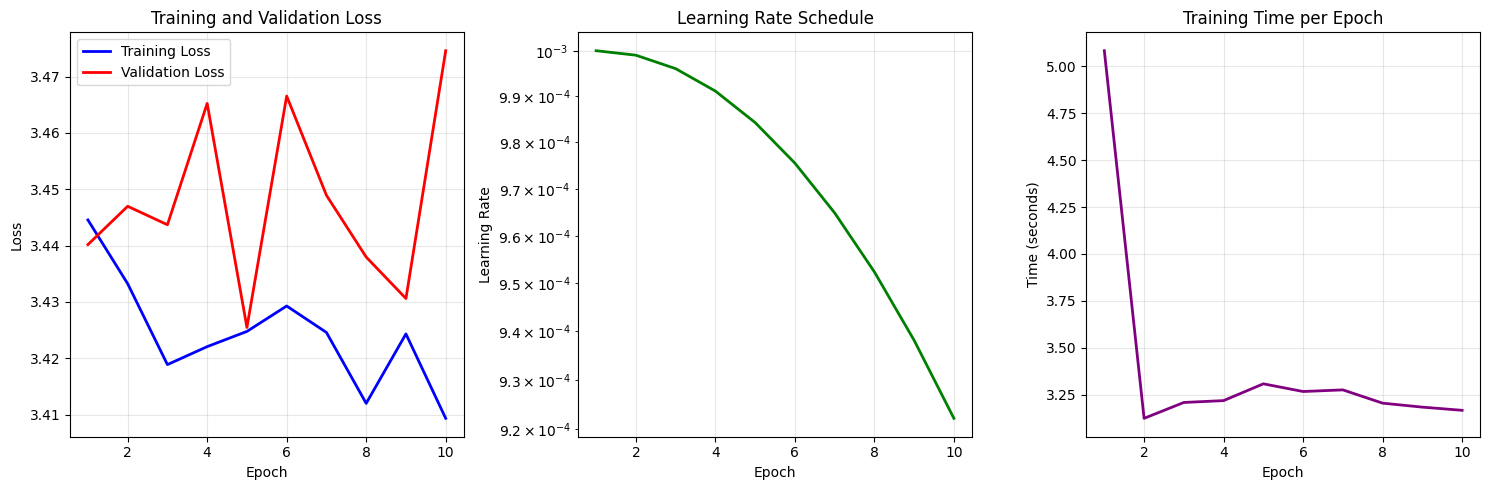

Epoch 11/50, Batch 0, Loss: 3.2832
Epoch 11/50: Train Loss: 3.3905, Val Loss: 3.4580, Time: 3.18s
Epoch 12/50, Batch 0, Loss: 3.3076
Epoch 12/50: Train Loss: 3.4073, Val Loss: 3.4868, Time: 3.20s
Epoch 13/50, Batch 0, Loss: 3.3956
Epoch 13/50: Train Loss: 3.3870, Val Loss: 3.4919, Time: 3.28s
Epoch 14/50, Batch 0, Loss: 3.4516
Epoch 14/50: Train Loss: 3.4013, Val Loss: 3.4580, Time: 3.23s
Epoch 15/50, Batch 0, Loss: 3.3435
Epoch 15/50: Train Loss: 3.3964, Val Loss: 3.5074, Time: 3.24s
Epoch 16/50, Batch 0, Loss: 3.4027
Epoch 16/50: Train Loss: 3.3920, Val Loss: 3.4610, Time: 3.24s
Epoch 17/50, Batch 0, Loss: 3.3839
Epoch 17/50: Train Loss: 3.3878, Val Loss: 3.4972, Time: 3.16s
Epoch 18/50, Batch 0, Loss: 3.3047
Epoch 18/50: Train Loss: 3.3824, Val Loss: 3.5565, Time: 3.11s
Epoch 19/50, Batch 0, Loss: 3.2149
Epoch 19/50: Train Loss: 3.3721, Val Loss: 3.5061, Time: 3.19s
Epoch 20/50, Batch 0, Loss: 3.1064
Epoch 20/50: Train Loss: 3.3327, Val Loss: 3.6009, Time: 3.27s


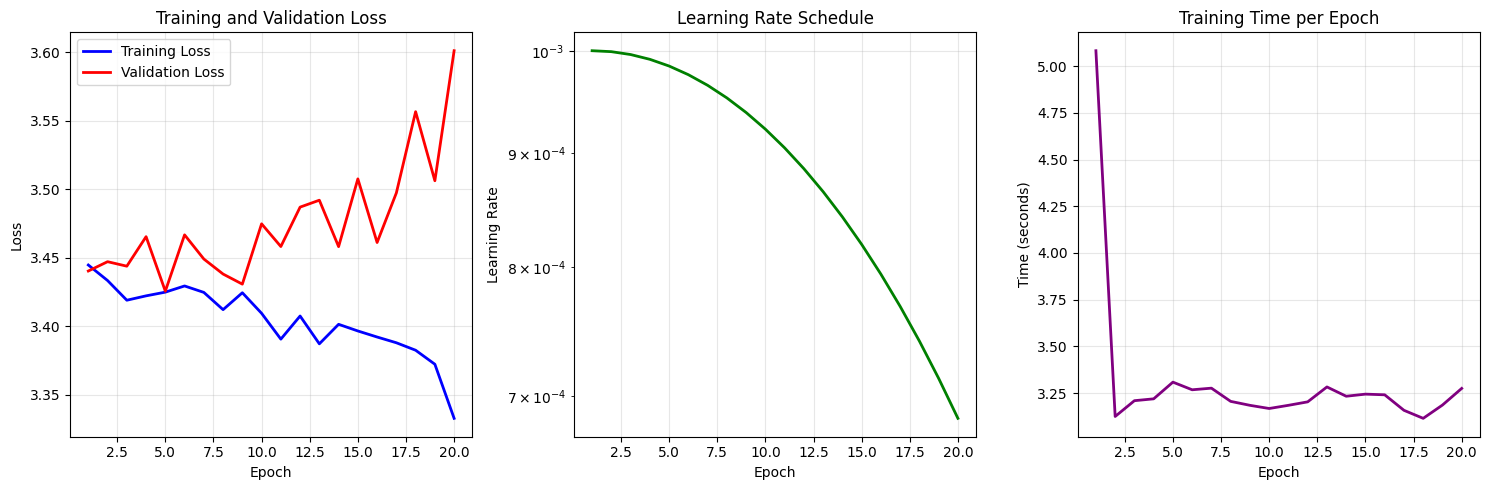

Epoch 21/50, Batch 0, Loss: 3.5359
Epoch 21/50: Train Loss: 3.3575, Val Loss: 3.5530, Time: 3.14s
Epoch 22/50, Batch 0, Loss: 3.2584
Epoch 22/50: Train Loss: 3.3259, Val Loss: 3.5643, Time: 3.25s
Epoch 23/50, Batch 0, Loss: 3.2190
Epoch 23/50: Train Loss: 3.3358, Val Loss: 3.5668, Time: 3.20s
Epoch 24/50, Batch 0, Loss: 3.3238
Epoch 24/50: Train Loss: 3.2898, Val Loss: 3.6888, Time: 3.28s
Epoch 25/50, Batch 0, Loss: 3.0596
Epoch 25/50: Train Loss: 3.2861, Val Loss: 3.6327, Time: 3.23s
Epoch 26/50, Batch 0, Loss: 3.1433
Epoch 26/50: Train Loss: 3.2649, Val Loss: 3.7233, Time: 3.15s
Epoch 27/50, Batch 0, Loss: 3.3126
Epoch 27/50: Train Loss: 3.2583, Val Loss: 3.6412, Time: 3.25s
Epoch 28/50, Batch 0, Loss: 3.1632
Epoch 28/50: Train Loss: 3.2276, Val Loss: 3.7061, Time: 3.31s
Epoch 29/50, Batch 0, Loss: 3.0659
Epoch 29/50: Train Loss: 3.1817, Val Loss: 3.8199, Time: 3.25s
Epoch 30/50, Batch 0, Loss: 3.1220
Epoch 30/50: Train Loss: 3.1898, Val Loss: 3.6446, Time: 3.22s


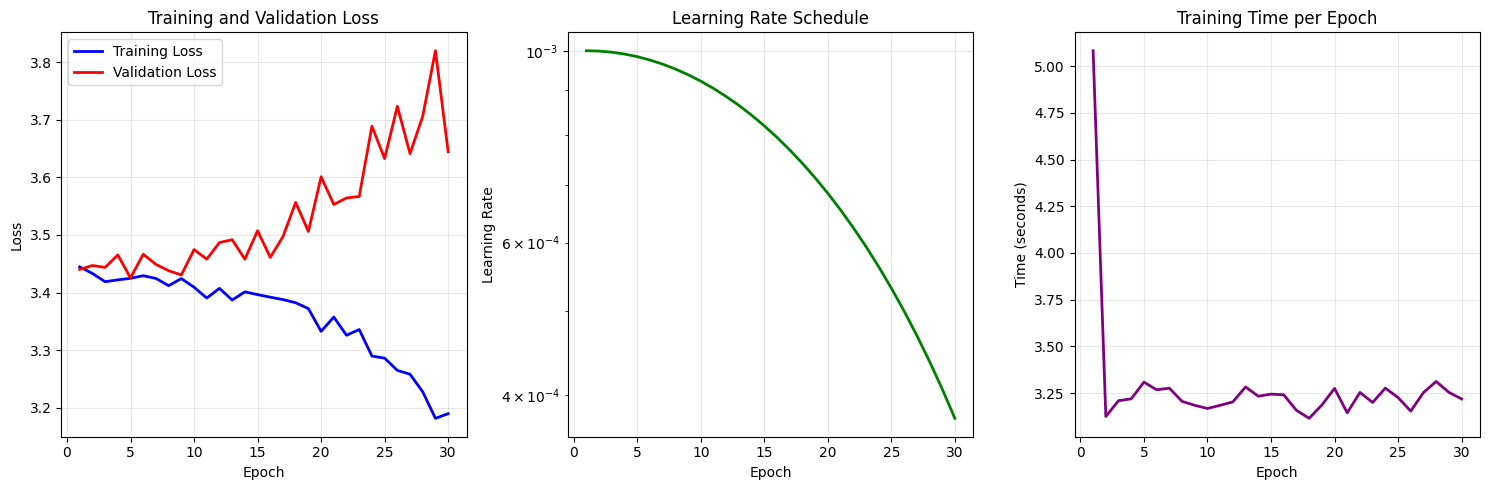

Epoch 31/50, Batch 0, Loss: 3.0814
Epoch 31/50: Train Loss: 3.1905, Val Loss: 3.7574, Time: 3.26s
Epoch 32/50, Batch 0, Loss: 2.7392
Epoch 32/50: Train Loss: 3.2109, Val Loss: 3.7331, Time: 3.27s
Epoch 33/50, Batch 0, Loss: 2.8573
Epoch 33/50: Train Loss: 3.0968, Val Loss: 3.9038, Time: 3.25s
Epoch 34/50, Batch 0, Loss: 2.8428
Epoch 34/50: Train Loss: 3.1581, Val Loss: 3.7972, Time: 3.42s
Epoch 35/50, Batch 0, Loss: 3.2127
Epoch 35/50: Train Loss: 3.1258, Val Loss: 3.8564, Time: 3.30s
Epoch 36/50, Batch 0, Loss: 2.8988
Epoch 36/50: Train Loss: 3.0682, Val Loss: 3.8112, Time: 3.19s
Epoch 37/50, Batch 0, Loss: 3.0100
Epoch 37/50: Train Loss: 3.0640, Val Loss: 3.8566, Time: 3.26s
Epoch 38/50, Batch 0, Loss: 2.9925
Epoch 38/50: Train Loss: 3.0449, Val Loss: 3.9107, Time: 3.22s
Epoch 39/50, Batch 0, Loss: 2.9787
Epoch 39/50: Train Loss: 3.0636, Val Loss: 3.9529, Time: 3.16s
Epoch 40/50, Batch 0, Loss: 2.8961
Epoch 40/50: Train Loss: 3.0120, Val Loss: 3.9569, Time: 3.28s


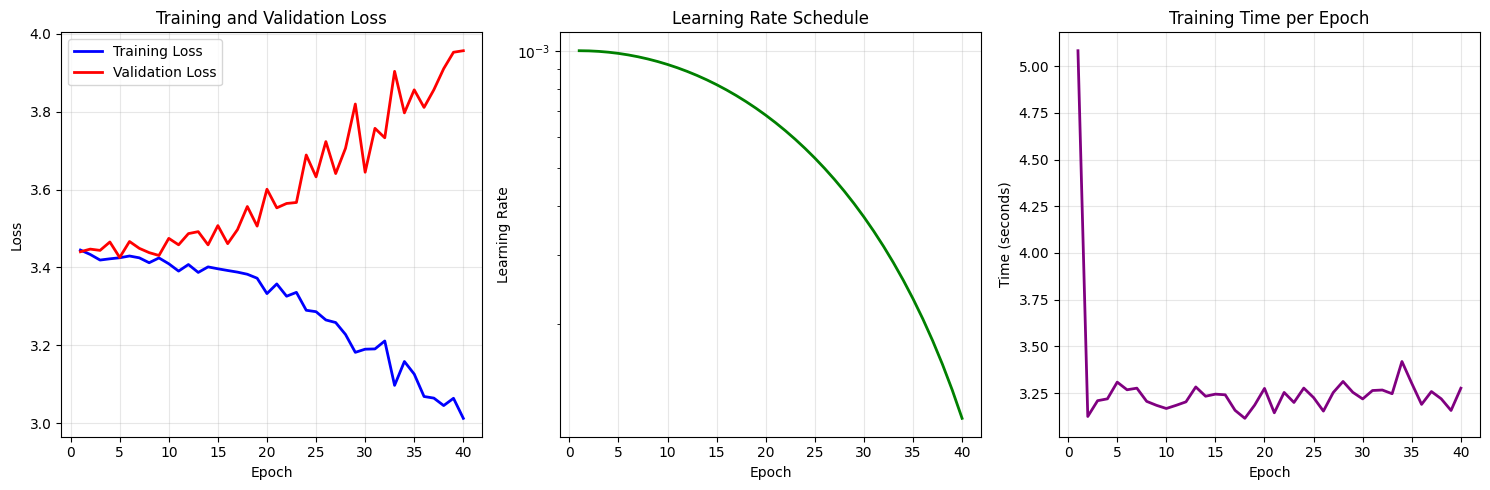

Epoch 41/50, Batch 0, Loss: 3.2992
Epoch 41/50: Train Loss: 3.0439, Val Loss: 3.9407, Time: 3.25s
Epoch 42/50, Batch 0, Loss: 2.8322
Epoch 42/50: Train Loss: 2.9538, Val Loss: 4.0376, Time: 3.18s
Epoch 43/50, Batch 0, Loss: 2.6103
Epoch 43/50: Train Loss: 2.9876, Val Loss: 3.9830, Time: 3.37s
Epoch 44/50, Batch 0, Loss: 2.9121
Epoch 44/50: Train Loss: 2.9927, Val Loss: 3.9926, Time: 3.24s
Epoch 45/50, Batch 0, Loss: 3.1151
Epoch 45/50: Train Loss: 2.9608, Val Loss: 3.9947, Time: 3.17s
Epoch 46/50, Batch 0, Loss: 3.1195
Epoch 46/50: Train Loss: 2.9984, Val Loss: 4.0199, Time: 3.17s
Epoch 47/50, Batch 0, Loss: 3.2647
Epoch 47/50: Train Loss: 2.9646, Val Loss: 3.9945, Time: 3.10s
Epoch 48/50, Batch 0, Loss: 2.6115
Epoch 48/50: Train Loss: 2.9987, Val Loss: 4.1301, Time: 3.07s
Epoch 49/50, Batch 0, Loss: 2.8969
Epoch 49/50: Train Loss: 2.9649, Val Loss: 3.9829, Time: 3.18s
Epoch 50/50, Batch 0, Loss: 2.9037
Epoch 50/50: Train Loss: 3.0347, Val Loss: 3.9361, Time: 3.16s


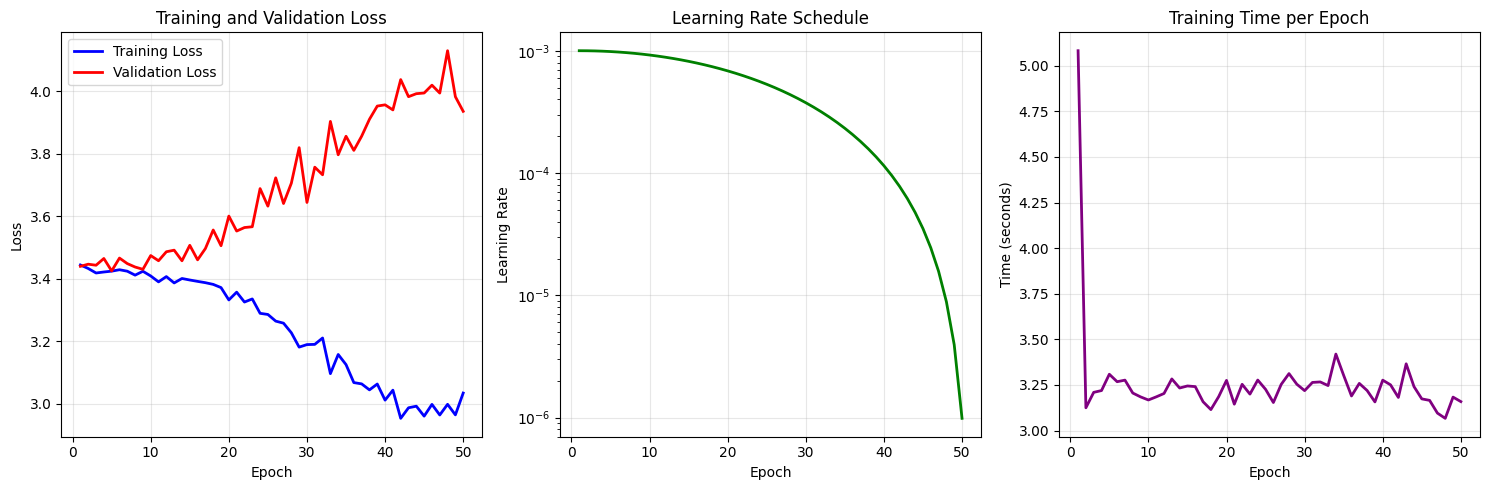

Training completed!


In [ ]:

data_dict = file_groups

trainer = ContrastivePretrainer(
    model_name='resnet50',
    pretrained=True,
    embedding_dim=128,
    temperature=0.1
)

key1 = 'cdm_lensed_no_noise'
key2 = 'uldm_lensed_no_noise'

trainer.train(
    data_dict=data_dict,
    key1=key1,
    key2=key2,
    epochs=50,
    lr=1e-3,
    batch_size=16,
    save_path=f'contrastive_{key1}_vs_{key2}.pth'
)

In [ ]:
a,b = trainer.create_data_loaders(data_dict = data_dict,key1 = key1,key2= key2)